## 어텐션을 이용한 텍스트 요약(Text Summarization with Attention mechanism)
- 텍스트 요약 : 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것
- 어텐션 매커니즘(attention mechanism) 기반의 시퀀스-투-시퀀스(Sequences-to-Sequence, seq2seq) 모델을 활용한 텍스트 요약
- 텍스트 요약은 크게 **추출적 요약(extractive summarization)**과 **추상적 요약(abstractive summarization)**으로 구분 <br>
  #### 1) 추출적 요약(extractive summarization)
  - 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법
  - 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들
  - 단점 : 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한됨
  
  #### 2) 추상적 요약(abstractive summarization)
  - 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법
  - 추출적 요약보다는 난이도가 높음
  - 단점 : 기본적으로 지도 학습 문제이기 때문에, 대량의 데이터가 필요함

In [1]:
# install required packages
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

# clear install verbose messages
from IPython.display import clear_output
clear_output()


# import packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
pd.options.display.max_colwidth = None
np.random.seed(seed=0)
nltk.download('stopwords')

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from attention import AttentionLayer


def show_table(df, sample_num=2):
  print('>>> shape :', df.shape)
  print('>>> No of NA :', df.isna().sum().sum())
  if len(df) <= sample_num*2:
    display(df)
  else:
    display(df.head(sample_num))
    display(df.tail(sample_num))
  pass


# pd : 1.1.5  |  np : 1.19.5  |  nltk : 3.2.5  |  tensorflow : 2.4.1
print(f'>>> pd : {pd.__version__}  |  np : {np.__version__}  |  nltk : {nltk.__version__}  |  tensorflow : {tensorflow.__version__}') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
>>> pd : 1.1.5  |  np : 1.19.5  |  nltk : 3.2.5  |  tensorflow : 2.5.0


## 1. 데이터 준비 (Prepare data)
- 아마존 리뷰 데이터 사용 (https://www.kaggle.com/snap/amazon-fine-food-reviews)

In [2]:
# load and check data
data = pd.read_csv('drive/MyDrive/mount_data/Amazon_Fine_Food_Reviews.csv', nrows=100000, usecols=['Text', 'Summary'])
show_table(data)

>>> shape : (100000, 2)
>>> No of NA : 2


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


,Summary,Text
99998,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra little something for the palate. I was not disappointed. To be completely honest, I usually drain most of the liquid as it is almost too much!"
99999,"This spicy noodle cures my cold, upset stomach, and headache every time!","I love this noodle and have it once or twice a week. The amazing thing is that when I don't feel well because of a cold, a hot bowl of this noodle will cure my upset stomach, headache, and running nose! This may not work for you, but you should definitely try it."


In [3]:
# remove Null or duplicated texts
print(data.nunique(), '\n')
data = data.dropna().drop_duplicates('Text', keep='last', ignore_index=True)
show_table(data)

Summary    72348
Text       88426
dtype: int64 

>>> shape : (88425, 2)
>>> No of NA : 0


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


,Summary,Text
88423,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra little something for the palate. I was not disappointed. To be completely honest, I usually drain most of the liquid as it is almost too much!"
88424,"This spicy noodle cures my cold, upset stomach, and headache every time!","I love this noodle and have it once or twice a week. The amazing thing is that when I don't feel well because of a cold, a hot bowl of this noodle will cure my upset stomach, headache, and running nose! This may not work for you, but you should definitely try it."


In [4]:
# contraction dictionary
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
print('>>> No of contractions :', len(contractions))

# stopwords
stop_words = set(stopwords.words('english'))
print('>>> No of stopwords :', len(stop_words), np.random.choice(list(stop_words), 10), '...')

>>> No of contractions : 120
>>> No of stopwords : 179 ['ours' "mightn't" 'shan' 'to' 's' 'whom' 'all' 'isn' 'won' 'theirs'] ...


In [5]:
# function to pre-process text
def preprocess_sentence(sentence, remove_stopwords=True):
  sentence = sentence.lower()                      # 소문자화
  sentence = BeautifulSoup(sentence, "lxml").text  # html 태그 제거
  sentence = re.sub('\([^)]*\)', '', sentence)     # 괄호로 닫힌 문자열 제거  EX) my husband (and myself) for...
  sentence = re.sub('"', '', sentence)             # 쌍따옴표 제거
  sentence = ' '.join([contractions[tk] if tk in contractions else tk for tk in sentence.split()])  # 약어 정규화
  sentence = re.sub("'s\b", '', sentence)          # 소유격 제거
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)    # 영어 외 문자 제거
  sentence = re.sub('m{2,}', 'mm', sentence)       # m이 3개 이상이면 2개로 변경  EX) hmmmm

  if remove_stopwords:
    sentence = ' '.join([tk for tk in sentence.split() if tk not in stop_words and len(tk)>1])  # 불용어 제거
  else:
    sentence = ' '.join([tk for tk in sentence.split() if len(tk)>1])  # 불용어 미제거
  return sentence


# check function output
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, remove_stopwords=False))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [6]:
%%time
# pre-process text
data['summary_cleaned'] = data['Summary'].apply(preprocess_sentence, remove_stopwords=False)
data['text_cleaned'] = data['Text'].apply(preprocess_sentence)

# remove empty text
data = data.replace('', np.nan).dropna()

show_table(data)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


>>> shape : (88355, 4)
>>> No of NA : 0


,Summary,Text,summary_cleaned,text_cleaned
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,good quality dog food,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",not as advertised,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo


,Summary,Text,summary_cleaned,text_cleaned
88423,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra little something for the palate. I was not disappointed. To be completely honest, I usually drain most of the liquid as it is almost too much!",spicy,like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liquid almost much
88424,"This spicy noodle cures my cold, upset stomach, and headache every time!","I love this noodle and have it once or twice a week. The amazing thing is that when I don't feel well because of a cold, a hot bowl of this noodle will cure my upset stomach, headache, and running nose! This may not work for you, but you should definitely try it.",this spicy noodle cures my cold upset stomach and headache every time,love noodle twice week amazing thing feel well cold hot bowl noodle cure upset stomach headache running nose may work definitely try


CPU times: user 49 s, sys: 813 ms, total: 49.8 s
Wall time: 49.6 s


>>> 텍스트의 최소 길이 : 2
>>> 텍스트의 최대 길이 : 1235
>>> 텍스트의 평균 길이 : 38.792428272310566
>>> 요약의 최소 길이 : 1
>>> 요약의 최대 길이 : 28
>>> 요약의 평균 길이 : 4.010718125742742



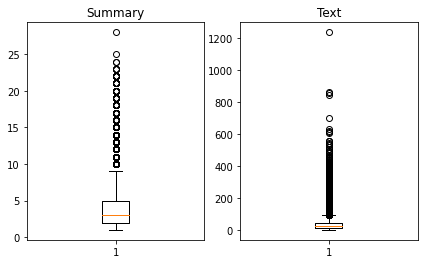

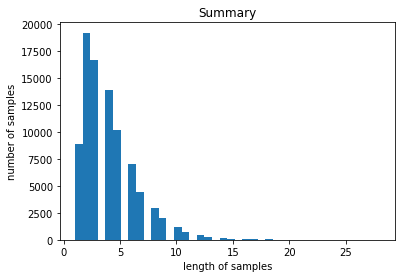

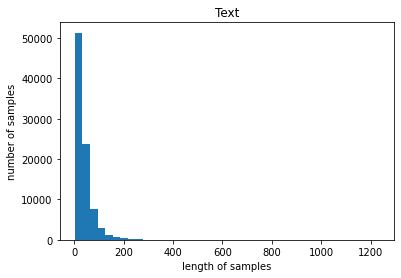

In [7]:
# check distribution of text length
text_len = [len(i.split()) for i in data['text_cleaned']]
summ_len = [len(i.split()) for i in data['summary_cleaned']]

print(f'>>> 텍스트의 최소 길이 : {min(text_len)}')
print(f'>>> 텍스트의 최대 길이 : {max(text_len)}')
print(f'>>> 텍스트의 평균 길이 : {np.mean(text_len)}')
print(f'>>> 요약의 최소 길이 : {min(summ_len)}')
print(f'>>> 요약의 최대 길이 : {max(summ_len)}')
print(f'>>> 요약의 평균 길이 : {np.mean(summ_len)}\n')

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
axes[0].boxplot(summ_len)
axes[0].set_title('Summary')
axes[1].boxplot(text_len)
axes[1].set_title('Text')
plt.show()

for tmp_title, tmp_list in zip(['Summary', 'Text'], [summ_len, text_len]):
  plt.hist(tmp_list, bins=40)
  plt.title(tmp_title)
  plt.xlabel('length of samples')
  plt.ylabel('number of samples')
  plt.show()

In [8]:
# set max length parameter
text_max_len = 50
summ_max_len = 8

print(f'>>> 길이가 {text_max_len} 이하인 Text 비율 : {len([i for i in text_len if i<=text_max_len])/len(text_len):.4f}')
print(f'>>> 길이가 {summ_max_len} 이하인 Summary 비율 : {len([i for i in summ_len if i<=summ_max_len])/len(summ_len):.4f}')

>>> 길이가 50 이하인 Text 비율 : 0.7745
>>> 길이가 8 이하인 Summary 비율 : 0.9424


In [9]:
# extract samples whose text length is less than max length
data = data[data.apply(lambda row : len(row['text_cleaned'].split())<=text_max_len and
                                    len(row['summary_cleaned'].split())<=summ_max_len, axis=1)].reset_index(drop=True)
show_table(data)

>>> shape : (65817, 4)
>>> No of NA : 0


,Summary,Text,summary_cleaned,text_cleaned
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,good quality dog food,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",not as advertised,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo


,Summary,Text,summary_cleaned,text_cleaned
65815,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great snack.",great ramen,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack
65816,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra little something for the palate. I was not disappointed. To be completely honest, I usually drain most of the liquid as it is almost too much!",spicy,like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liquid almost much


In [10]:
# add special tokens for seq2seq model
data['decoder_input'] = 'sostoken ' + data['summary_cleaned']
data['decoder_target'] = data['summary_cleaned'] + ' eostoken'

# initialize train data for seq2seq model
encoder_input = data['text_cleaned'].values
decoder_input = data['decoder_input'].values
decoder_target = data['decoder_target'].values

show_table(data[[c for c in data if '_' in c]])

>>> shape : (65817, 4)
>>> No of NA : 0


,summary_cleaned,text_cleaned,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostoken not as advertised,not as advertised eostoken


,summary_cleaned,text_cleaned,decoder_input,decoder_target
65815,great ramen,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,sostoken great ramen,great ramen eostoken
65816,spicy,like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liquid almost much,sostoken spicy,spicy eostoken


In [11]:
# shuffle data order
indices = np.arange(len(encoder_input))
np.random.shuffle(indices)
print(f'>>> shuffle indices : {indices}\n')

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# split data into Train & Validation dataset
val_num = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[val_num:]
decoder_input_train = decoder_input[val_num:]
decoder_target_train = decoder_target[val_num:]

encoder_input_valid = encoder_input[:val_num]
decoder_input_valid = decoder_input[:val_num]
decoder_target_valid = decoder_target[:val_num]

print('>>> size X_train :', len(encoder_input_train))
print('>>> size y_train :', len(decoder_target_train))
print('>>> size X_test  :', len(encoder_input_valid))
print('>>> size y_test  :', len(decoder_target_valid))

>>> shuffle indices : [ 4496 31705 61885 ... 52620 39512 48600]

>>> size X_train : 52654
>>> size y_train : 52654
>>> size X_test  : 13163
>>> size y_test  : 13163


In [12]:
# build vocab - input data
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

# check rare tokens in vocab (whose freq less than threshold)
threshold = 7
total_word_cnt = len(src_tokenizer.word_counts)

rare_word_cnt = 0
total_freq = 0
rare_word_freq = 0
for key, val in src_tokenizer.word_counts.items():
  total_freq += val
  
  if val < threshold:
    rare_word_cnt += 1
    rare_word_freq += val

print(f'>>> vocab size : {total_word_cnt}')
print(f'>>> number of rare words(freq less than {threshold}) : {rare_word_cnt}')
print(f'>>> vocab size without rare words : {total_word_cnt - rare_word_cnt}')
print(f'>>> ratio of rare words in vocab : {rare_word_cnt/total_word_cnt*100:.3f} %')
print(f'>>> ratio of rare words\' freq to total words\' freq : {rare_word_freq/total_freq*100:.3f} %')

# build vocab with size limit - input data
src_vocab_size = min(8000, total_word_cnt - rare_word_cnt)  # limit vocab size to 8000 or less
src_tokenizer = Tokenizer(num_words=src_vocab_size)
src_tokenizer.fit_on_texts(encoder_input_train)

# integer encoding - input data
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_valid = src_tokenizer.texts_to_sequences(encoder_input_valid)

# check encoding result
print('\n>>> final vocab size (with limit) :', src_tokenizer.num_words)
print('>>> sample sequences after encoding:')
for seq in encoder_input_train[:3]:
  print('\t', seq)

>>> vocab size : 32127
>>> number of rare words(freq less than 7) : 23902
>>> vocab size without rare words : 8225
>>> ratio of rare words in vocab : 74.398 %
>>> ratio of rare words' freq to total words' freq : 3.412 %

>>> final vocab size (with limit) : 8000
>>> sample sequences after encoding:
	 [112, 4, 325, 15, 514, 35, 590, 215, 174]
	 [729, 20, 7149, 309, 152, 4609, 220, 90, 62, 3342, 949, 47, 77, 53, 333, 600, 24, 1269, 402, 3153, 30, 68]
	 [58, 354, 1642, 113, 825, 613, 113, 128, 643, 148, 27, 132, 147, 36, 847, 2259, 1487, 248, 115, 3998]


In [13]:
# build vocab - target data
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

# check rare tokens in vocab (whose freq less than threshold)
threshold = 6
total_word_cnt = len(tar_tokenizer.word_counts)

rare_word_cnt = 0
total_freq = 0
rare_word_freq = 0
for key, val in tar_tokenizer.word_counts.items():
  total_freq += val
  
  if val < threshold:
    rare_word_cnt += 1
    rare_word_freq += val

print(f'>>> vocab size : {total_word_cnt}')
print(f'>>> number of rare words(freq less than {threshold}) : {rare_word_cnt}')
print(f'>>> vocab size without rare words : {total_word_cnt - rare_word_cnt}')
print(f'>>> ratio of rare words in vocab : {rare_word_cnt/total_word_cnt*100:.3f} %')
print(f'>>> ratio of rare words\' freq to total words\' freq : {rare_word_freq/total_freq*100:.3f} %')

# build vocab with size limit - target data
## NOTE : fit on both input & target train (to include all special tokens)
tar_vocab_size = min(2000, total_word_cnt - rare_word_cnt)  # limit vocab size to 2000 or less
tar_tokenizer = Tokenizer(num_words=tar_vocab_size)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# integer encoding - target data
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_valid = tar_tokenizer.texts_to_sequences(decoder_input_valid)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_valid = tar_tokenizer.texts_to_sequences(decoder_target_valid)

# check encoding result
print('\n>>> final vocab size (with limit) :', tar_tokenizer.num_words)
print('>>> sample sequences after encoding:')
for seq in decoder_input_train[:3]:
  print('\t', seq)

>>> vocab size : 10490
>>> number of rare words(freq less than 6) : 8116
>>> vocab size without rare words : 2374
>>> ratio of rare words in vocab : 77.369 %
>>> ratio of rare words' freq to total words' freq : 5.906 %

>>> final vocab size (with limit) : 2000
>>> sample sequences after encoding:
	 [1, 195, 149, 87, 51, 190]
	 [1, 3]
	 [1, 4, 7]


In [14]:
# get indices of samples with empty text
drop_train = [idx for idx, lst in enumerate(decoder_input_train) if len(lst)==1]
drop_valid = [idx for idx, lst in enumerate(decoder_input_valid) if len(lst)==1]
print(f'>>> Removing {len(drop_train)} trian samples  & {len(drop_valid)} valid samples...\n')

# remove samples with empty text
# encoder_input_train  = [i for idx, i in enumerate(encoder_input_train)  if idx not in drop_train]  # slower, but not deprecated
encoder_input_train  = np.delete(encoder_input_train,  drop_train).tolist()  # faster, but deprecated
decoder_input_train  = np.delete(decoder_input_train,  drop_train).tolist()
decoder_target_train = np.delete(decoder_target_train, drop_train).tolist()

encoder_input_valid  = np.delete(encoder_input_valid,  drop_valid).tolist()
decoder_input_valid  = np.delete(decoder_input_valid,  drop_valid).tolist()
decoder_target_valid = np.delete(decoder_target_valid, drop_valid).tolist()

# check the dataset size after 
print('>>> size X_train :', len(encoder_input_train))
print('>>> size y_train :', len(decoder_target_train))
print('>>> size X_test  :', len(encoder_input_valid))
print('>>> size y_test  :', len(decoder_target_valid))
print()

>>> Removing 1270 trian samples  & 350 valid samples...

>>> size X_train : 51384
>>> size y_train : 51384
>>> size X_test  : 12813
>>> size y_test  : 12813



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
# add padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summ_max_len+1)  # add 1 to maxlen due to special token
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summ_max_len+1)  # add 1 to maxlen due to special token

encoder_input_valid = pad_sequences(encoder_input_valid, maxlen=text_max_len)
decoder_input_valid = pad_sequences(decoder_input_valid, maxlen=summ_max_len+1)  # add 1 to maxlen due to special token
decoder_target_valid = pad_sequences(decoder_target_valid, maxlen=summ_max_len+1)  # add 1 to maxlen due to special token

# check the result
print(encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape, encoder_input_valid.shape, decoder_input_valid.shape, decoder_target_valid.shape)
print(encoder_input_train[0])

(51384, 50) (51384, 9) (51384, 9) (12813, 50) (12813, 9) (12813, 9)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 112   4 325  15 514  35 590 215 174]


## 2. seq2seq + attention 요약 모델 설계 및 훈련 (Build & Train the model)

In [16]:
embedding_dim = 128
hidden_size = 256


# Encoder layers
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)

enc_lstm1 = LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
enc_out1, state_h1, state_c1 = enc_lstm1(enc_emb)

enc_lstm2 = LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
enc_out2, state_h2, state_c2 = enc_lstm2(enc_out1)

enc_lstm3 = LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
enc_out3, state_h3, state_c3 = enc_lstm3(enc_out2)


# Decoder layers
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(tar_vocab_size, embedding_dim)(decoder_inputs)

dec_lstm1 = LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
dec_out1, _, _ = dec_lstm1(inputs=dec_emb, initial_state=[state_h3, state_c3])


# Decoder ouput layer
dec_softmax_out = Dense(tar_vocab_size, activation='softmax')(dec_out1)


# generate model (seq2seq with LSTM)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=dec_softmax_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [17]:
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer(inputs=[enc_out3, dec_out1])

# Concatenate attention outputs & decoder hidden states
dec_concat_input = Concatenate(axis=-1, name='concat_layer')([dec_out1, attn_out])

# Decoder ouput layer
dec_softmax_out = Dense(tar_vocab_size, activation='softmax')(dec_concat_input)


# generate model (seq2seq with attention)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=dec_softmax_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________